In [1]:
#!pip install tensorflow==1.14.0

In [2]:
#!pip install keras==2.2.5

In [3]:
import os
os.environ["PYTHONHASHSEED"] = "13"
os.environ["CUDA_VISIBLE_DEVICES"] = ""

import numpy as np
import tensorflow as tf
import random as rn

# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.

np.random.seed(13)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.

rn.seed(13)

# Force TensorFlow to use single thread.
# Multiple threads are a potential source of non-reproducible results.
# For further details, see: https://stackoverflow.com/questions/42022950/

session_conf = tf.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)

from keras import backend as K

# The below tf.set_random_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see:
# https://www.tensorflow.org/api_docs/python/tf/set_random_seed

tf.set_random_seed(13)

sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

Using TensorFlow backend.


In [7]:
import gc
import warnings

import lightgbm as lgb
import pandas as pd

from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from tqdm.notebook import tqdm

import keras
from keras.models import Sequential
from keras.layers import BatchNormalization, Dense, Dropout

path_data = "../input/ashrae-energy-prediction/"
path_train = path_data + "train.csv"
path_test = path_data + "test.csv"
path_building = path_data + "building_metadata.csv"
path_weather_train = path_data + "weather_train.csv"
path_weather_test = path_data + "weather_test.csv"

myfavouritenumber = 13
seed = myfavouritenumber

warnings.filterwarnings("ignore")

In [8]:
site_id = 7

In [10]:
df_train = pd.read_csv(path_train)
df_test = pd.read_csv(path_test)

building = pd.read_csv(path_building)

weather_train = pd.read_csv(path_weather_train)
weather_test = pd.read_csv(path_weather_test)

weather_train.drop(["sea_level_pressure", "wind_direction", "wind_speed"], axis=1, inplace=True)
weather_test.drop(["sea_level_pressure", "wind_direction", "wind_speed"], axis=1, inplace=True)

weather_train = weather_train.groupby("site_id").apply(lambda group: group.interpolate(limit_direction="both"))
weather_test = weather_test.groupby("site_id").apply(lambda group: group.interpolate(limit_direction="both"))

df_train = df_train.merge(building, on="building_id")
df_test = df_test.merge(building, on="building_id")

df_train = df_train[df_train.site_id == site_id]
df_test = df_test[df_test.site_id == site_id]

df_train = df_train[~((df_train.building_id == 789) & (df_train.meter_reading == 0))]
df_train = df_train[~((df_train.building_id == 790) & (df_train.meter_reading == 0))]
df_train = df_train[~((df_train.building_id == 791) & (df_train.meter_reading == 0))]
df_train = df_train[~((df_train.building_id == 792) & (df_train.meter_reading == 0))]
df_train = df_train[~((df_train.building_id == 795) & (df_train.meter == 0) & (df_train.meter_reading == 0))]
df_train = df_train[~((df_train.building_id == 798) & (df_train.meter_reading == 0))]
df_train = df_train[~((df_train.building_id == 799) & (df_train.meter == 0) & (df_train.meter_reading == 0))]
df_train = df_train[~((df_train.building_id == 801) & (df_train.meter_reading == 0))]
df_train = df_train[~((df_train.building_id == 802) & (df_train.meter_reading == 0))]

df_train = df_train[df_train.meter == 0]

df_train = df_train.merge(weather_train, on=["site_id", "timestamp"], how="left")
df_test = df_test.merge(weather_test, on=["site_id", "timestamp"], how="left")

df_train.timestamp = pd.to_datetime(df_train.timestamp, format='%Y-%m-%d %H:%M:%S')
df_test.timestamp = pd.to_datetime(df_test.timestamp, format='%Y-%m-%d %H:%M:%S')

df_train.building_id = df_train.building_id.astype("str")
df_test.building_id = df_test.building_id.astype("str")

df_train["log_meter_reading"] = np.log1p(df_train.meter_reading)

del building
gc.collect()

0

In [11]:
df_train["hour"] = df_train.timestamp.dt.hour.astype("str")
df_test["hour"] = df_test.timestamp.dt.hour.astype("str")

df_train["weekday"] = df_train.timestamp.dt.weekday.astype("str")
df_test["weekday"] = df_test.timestamp.dt.weekday.astype("str")

df_train["month"] = df_train.timestamp.dt.month.astype("str")
df_test["month"] = df_test.timestamp.dt.month.astype("str")

In [12]:
features = [
    "building_id",
    "square_feet",
    "year_built",
    "floor_count",
    "primary_use",
    "air_temperature",
    "cloud_coverage",
    "dew_temperature",
    "precip_depth_1_hr",
    "hour",
    "weekday",
    "month"
]

In [13]:
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [14]:
cv = 4
folds = KFold(n_splits = cv, shuffle = False, random_state = seed)

df_cv = []
df_preds = []

Building Model for site_id 7 and meter 0
Preparing Site: 7 , meter: 0 , Fold: 1




Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 70880 samples, validate on 23627 samples
Epoch 1/31
 - 2s - loss: 6.9738 - val_loss: 6.6631
Epoch 2/31
 - 1s - loss: 6.4958 - val_loss: 6.0286
Epoch 3/31
 - 1s - loss: 5.7306 - val_loss: 5.0056
Epoch 4/31
 - 1s - loss: 4.6767 - val_loss: 3.6988
Epoch 5/31
 - 1s - loss: 3.4994 - val_loss: 2.2607
Epoch 6/31
 - 1s - loss: 2.6303 - val_loss: 1.1698
Epoch 7/31
 - 1s - loss: 2.2618 - val_loss: 0.6941
Epoch 8/31
 - 1s - loss: 2.1739 - val_loss: 0.5987
Epoch 9/31
 - 1s - loss: 2.1543 - val_loss: 0.5784
Epoch 10/31
 - 1s - loss: 2.1429 - val_loss: 0.5787
Epoch 11/31
 - 1s - loss: 2.1316 - val_loss: 0.5743
Epoch 12/31
 - 1s - loss: 2.1220 - val_loss: 0.5755
Epoch 13/31
 - 1s - loss: 2.1146 - val_l

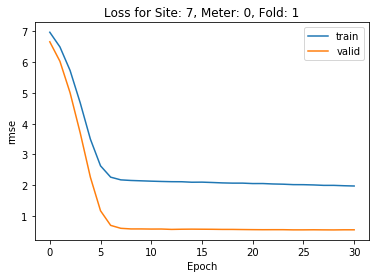

Preparing Site: 7 , meter: 0 , Fold: 2
Train on 70880 samples, validate on 23627 samples
Epoch 1/31
 - 2s - loss: 6.9010 - val_loss: 6.8399
Epoch 2/31
 - 0s - loss: 6.2877 - val_loss: 6.0847
Epoch 3/31
 - 1s - loss: 5.4462 - val_loss: 4.9764
Epoch 4/31
 - 0s - loss: 4.3489 - val_loss: 3.5531
Epoch 5/31
 - 0s - loss: 3.2109 - val_loss: 2.2132
Epoch 6/31
 - 0s - loss: 2.4745 - val_loss: 1.2691
Epoch 7/31
 - 0s - loss: 2.1933 - val_loss: 0.9941
Epoch 8/31
 - 0s - loss: 2.1446 - val_loss: 0.9372
Epoch 9/31
 - 1s - loss: 2.1299 - val_loss: 0.9209
Epoch 10/31
 - 1s - loss: 2.1184 - val_loss: 0.9163
Epoch 11/31
 - 1s - loss: 2.1107 - val_loss: 0.9089
Epoch 12/31
 - 1s - loss: 2.0996 - val_loss: 0.9014
Epoch 13/31
 - 1s - loss: 2.0919 - val_loss: 0.8905
Epoch 14/31
 - 1s - loss: 2.0793 - val_loss: 0.8838
Epoch 15/31
 - 1s - loss: 2.0763 - val_loss: 0.8752
Epoch 16/31
 - 1s - loss: 2.0724 - val_loss: 0.8726
Epoch 17/31
 - 1s - loss: 2.0658 - val_loss: 0.8700
Epoch 18/31
 - 1s - loss: 2.0587 - v

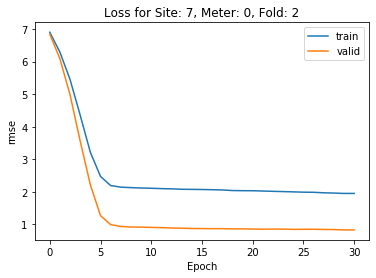

Preparing Site: 7 , meter: 0 , Fold: 3
Train on 70880 samples, validate on 23627 samples
Epoch 1/31
 - 2s - loss: 7.0298 - val_loss: 6.3274
Epoch 2/31
 - 1s - loss: 6.4158 - val_loss: 5.6750
Epoch 3/31
 - 1s - loss: 5.6096 - val_loss: 4.6465
Epoch 4/31
 - 1s - loss: 4.5299 - val_loss: 3.3202
Epoch 5/31
 - 1s - loss: 3.3204 - val_loss: 1.9804
Epoch 6/31
 - 1s - loss: 2.4189 - val_loss: 1.4222
Epoch 7/31
 - 1s - loss: 2.1065 - val_loss: 1.2527
Epoch 8/31
 - 1s - loss: 2.0694 - val_loss: 1.2170
Epoch 9/31
 - 1s - loss: 2.0542 - val_loss: 1.2088
Epoch 10/31
 - 1s - loss: 2.0519 - val_loss: 1.2042
Epoch 11/31
 - 1s - loss: 2.0379 - val_loss: 1.2024
Epoch 12/31
 - 1s - loss: 2.0314 - val_loss: 1.1922
Epoch 13/31
 - 0s - loss: 2.0142 - val_loss: 1.1774
Epoch 14/31
 - 1s - loss: 2.0062 - val_loss: 1.1645
Epoch 15/31
 - 1s - loss: 2.0092 - val_loss: 1.1340
Epoch 16/31
 - 0s - loss: 1.9915 - val_loss: 1.1142
Epoch 17/31
 - 1s - loss: 1.9778 - val_loss: 1.1073
Epoch 18/31
 - 1s - loss: 1.9689 - v

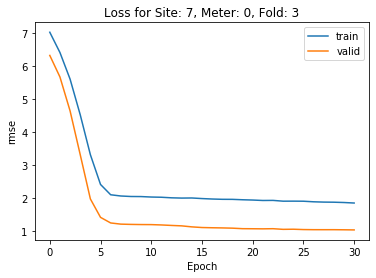

Preparing Site: 7 , meter: 0 , Fold: 4
Train on 70881 samples, validate on 23626 samples
Epoch 1/31
 - 2s - loss: 7.0057 - val_loss: 6.5718
Epoch 2/31
 - 1s - loss: 6.3763 - val_loss: 5.8772
Epoch 3/31
 - 1s - loss: 5.3554 - val_loss: 4.8563
Epoch 4/31
 - 1s - loss: 4.0161 - val_loss: 3.6117
Epoch 5/31
 - 1s - loss: 2.6904 - val_loss: 2.5853
Epoch 6/31
 - 1s - loss: 2.0157 - val_loss: 2.1859
Epoch 7/31
 - 1s - loss: 1.8662 - val_loss: 2.0845
Epoch 8/31
 - 1s - loss: 1.8427 - val_loss: 2.0608
Epoch 9/31
 - 1s - loss: 1.8287 - val_loss: 2.0633
Epoch 10/31
 - 1s - loss: 1.8349 - val_loss: 2.0660
Epoch 11/31
 - 1s - loss: 1.8136 - val_loss: 2.0658
Epoch 12/31
 - 1s - loss: 1.7966 - val_loss: 2.0573
Epoch 13/31
 - 1s - loss: 1.7881 - val_loss: 2.0634
Epoch 14/31
 - 1s - loss: 1.7789 - val_loss: 2.0605
Epoch 15/31
 - 1s - loss: 1.7752 - val_loss: 2.0655
Epoch 16/31
 - 1s - loss: 1.7653 - val_loss: 2.0593
Epoch 17/31
 - 1s - loss: 1.7542 - val_loss: 2.0591
Epoch 18/31
 - 1s - loss: 1.7427 - v

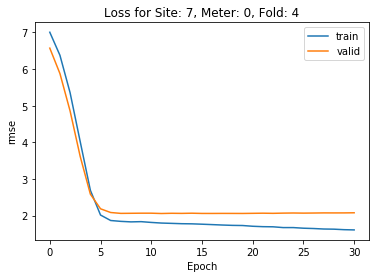


CV RMSE for Site: 7 and Meter: 0 is 1.561429348778686

CV RMSE for Site: 7 is 1.561429348778686


In [15]:
for meter in df_train.meter.unique():
    print("Building Model for site_id", site_id, "and meter", meter)
        
    df_train_site_meter = df_train[df_train.meter == meter].reset_index(drop=True)
    df_test_site_meter = df_test[df_test.meter == meter].reset_index(drop=True)
    
    pred_val = np.zeros(df_train_site_meter.shape[0])
    pred_test = np.zeros(df_test_site_meter.shape[0])

    row_ids_test = df_test_site_meter.row_id
    y_train_site_meter = df_train_site_meter.log_meter_reading.values
    
    df_train_site_meter = df_train_site_meter[features]
    df_test_site_meter = df_test_site_meter[features]

    df_train_site_meter = pd.get_dummies(df_train_site_meter)
    df_test_site_meter = pd.get_dummies(df_test_site_meter)
        
    for k, (train_idx, valid_idx) in enumerate(folds.split(df_train_site_meter, y_train_site_meter)):
        print("Preparing Site:", site_id, ", meter:", meter, ", Fold:", k+1)
        
        X_train, y_train = df_train_site_meter.iloc[train_idx], y_train_site_meter[train_idx]
        X_valid, y_valid = df_train_site_meter.iloc[valid_idx], y_train_site_meter[valid_idx]
        
        X_train.dropna(axis=1, how="all", inplace=True)
        X_train = X_train.loc[:, (X_train != X_train.iloc[0]).any()]

        X_valid = X_valid[X_train.columns]
        X_test = df_test_site_meter[X_train.columns]
        
        df_means = pd.concat([X_train, X_valid, X_test], ignore_index=True).mean()
        X_train.fillna(df_means, inplace=True)
        X_valid.fillna(df_means, inplace=True)
        X_test.fillna(df_means, inplace=True)
        
        sc = MinMaxScaler()
        sc.fit(pd.concat([X_train, X_valid, X_test], ignore_index=True))
        
        X_train = np.array(sc.transform(X_train))
        X_valid = np.array(sc.transform(X_valid))
        X_test = np.array(sc.transform(X_test))
        
        model = Sequential()
        model.add(Dense(32, input_dim=X_train.shape[1], activation="relu", kernel_initializer=keras.initializers.glorot_uniform(seed=seed)))
        model.add(BatchNormalization())
        model.add(Dropout(0.2))
        model.add(Dense(8, activation="tanh", kernel_initializer=keras.initializers.glorot_uniform(seed=seed)))
        model.add(BatchNormalization())
        model.add(Dropout(0.2))
        model.add(Dense(4, activation="tanh", kernel_initializer=keras.initializers.glorot_uniform(seed=seed)))
        model.add(BatchNormalization())
        model.add(Dropout(0.2))
        model.add(Dense(1))
        model.compile(loss=rmse, optimizer="adam")
        
        model_ffnn = model.fit(X_train, y_train, epochs=31, batch_size=500, validation_data=(X_valid, y_valid), verbose=2, shuffle=False)

        plt.plot(model_ffnn.history["loss"])
        plt.plot(model_ffnn.history["val_loss"])
        plt.title("Loss for Site: " + str(site_id) + ", Meter: " + str(meter) + ", Fold: " + str(k+1))
        plt.ylabel("rmse")
        plt.xlabel("Epoch")
        plt.legend(["train", "valid"], loc="upper right")
        plt.show()
        
        pred_val[valid_idx] = model.predict(X_valid).ravel()
        pred_test += model.predict(X_test).ravel() / cv
        
        gc.collect()
        
    df_valid = pd.DataFrame({"site_id": site_id, "meter": meter, "meter_reading": np.expm1(y_train_site_meter), "pred_ffnn": np.clip(np.expm1(pred_val), 0, a_max=None)})
    df_pred = pd.DataFrame({"row_id": row_ids_test, "meter_reading": np.clip(np.expm1(pred_test), 0, a_max=None)})
    
    df_cv.append(df_valid)
    df_preds.append(df_pred)
    
    gc.collect()
    
    print("\nCV RMSE for Site:", site_id, "and Meter:", meter, "is", np.sqrt(mean_squared_error(np.log1p(df_valid.meter_reading), np.log1p(df_valid.pred_ffnn))))

df_cv = pd.concat(df_cv)
print("\nCV RMSE for Site:", site_id, "is", np.sqrt(mean_squared_error(np.log1p(df_cv.meter_reading), np.log1p(df_cv.pred_ffnn))))


In [16]:
df_preds = pd.concat(df_preds)
df_preds.to_csv("../sub/ffnn_pred_site_" + str(site_id) + ".csv", index=False)

AttributeError: 'list' object has no attribute 'to_csv'